# Notebook 2: Baseline Implementation

## Overview

When building RAG systems, intuition isn't enough - we need objective metrics to guide our decisions. Teams often waste resources on complex architectures without clear evidence they outperform simpler approaches. This notebook introduces a systematic framework for evaluating and comparing different retrieval strategies.


## Setup

First, let's install the necessary libraries:

In [55]:
%pip install openai chromadb sentence_transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [56]:
import openai
import chromadb
from chromadb.utils import embedding_functions
from sentence_transformers import CrossEncoder
import pandas as pd
import getpass
import numpy as np

# Display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

# Initialize OpenAI
openai.api_key = getpass.getpass('Enter your OpenAI API key: ')

First, let's load the evaluation dataset we created in the previous notebook:

In [57]:
# Load the evaluation dataset
eval_df = pd.read_json('../data/evalset/ai_papers_eval_dataset.json')
print(f"Loaded {len(eval_df)} evaluation examples")
print(eval_df.head())

Loaded 26 evaluation examples
                  id                                                                                             document                                                                                                query                                                                                               answer
0  gpt_1.pdf_chunk_0  Improving Language Understanding\nby Generative Pre-Training\nAlec Radford\nOpenAI\nalec@openai....                             details on the generative pre-training methodology outlined in the paper  The document discusses a generative pre-training methodology that involves training a language m...
1  gpt_1.pdf_chunk_1  speciﬁc task. In contrast to previous approaches, we make use of task-aware input\ntransformatio...                                  details on the task-aware input transformations used in fine-tuning  The document mentions that task-aware input transformations are utilized during fine-tuning to a..

Let's set up a ChromDB collection to store our documents

In [58]:
def create_collection_with_embedding(chroma_client, collection_name, model_name, eval_df):
    """Create a ChromaDB collection with a specific embedding model"""
    # Initialize embedding function
    embedding_function = embedding_functions.SentenceTransformerEmbeddingFunction(
        model_name=model_name
    )
    
    # Delete collection if it exists
    try:
        chroma_client.delete_collection(name=collection_name)
        print(f"Deleted existing collection {collection_name}")
    except:
        print(f"No existing collection {collection_name} to delete")
    
    # Create new collection
    collection = chroma_client.create_collection(
        name=collection_name,
        embedding_function=embedding_function
    )
    
    # Add documents to Chroma
    for _, row in eval_df.iterrows():
        collection.upsert(
            documents=[row['document']],
            ids=[row['id']],
            metadatas=[{'id': row['id'], 'query': row['query'], 'answer': row['answer']}]
        )
    
    print(f"Created collection {collection_name} with {collection.count()} documents using {model_name}")
    return collection

Let's define the metrics we'll use to evaluate our retrieval system. The two main metrics we'll focus on are:

1. **Recall@k**: The proportion of relevant documents that are retrieved in the top k results
2. **Mean Reciprocal Rank (MRR@k)**: Measures where in the ranking the first relevant document appears

In [59]:
metrics = [("mrr", calculate_mrr), ("recall", calculate_recall)]
k_values = [1, 3, 5, 10, 15, 20, 25, 30]

def calculate_mrr(predictions: list[str], ground_truth: list[str]):
    mrr = 0
    for label in ground_truth:
        if label in predictions:
            mrr = max(mrr, 1 / (predictions.index(label) + 1))
    return mrr

def calculate_recall(predictions: list[str], ground_truth: list[str]):
    return len([label for label in ground_truth if label in predictions]) / len(ground_truth)

def evaluate_retrieval(predictions, ground_truth):
    scores = {}
    for metric, score_fn in metrics:
        for subset_k in k_values:
            scores[f"{metric}@{subset_k}"] = score_fn(predictions[:subset_k], ground_truth)

    return scores

Now let's implement the function for retrieving (and optionally reranking) queries

In [81]:
def retrieve(question, collection, reranker = None, max_k=30):
    results = collection.query(
        query_texts=[question],
        n_results=max_k
    )

    if reranker:
        return rerank_results(question, results, reranker, max_k)
    
    return {"ids": results['ids'][0], "documents": results['documents'][0]}

In [83]:
def rerank_results(query, results, reranker_model, top_k=30):
    # Format results
    results = {"ids": results['ids'][0], "documents": results['documents'][0]}
    print("before reranking:", results)
    # Initialize cross-encoder
    cross_encoder = CrossEncoder(reranker_model)
    
    # Create pairs for reranking
    pairs = [(query, doc) for doc in results["documents"]]
    scores = cross_encoder.predict(pairs)
    
    # Sort by scores
    reranked_indices = np.argsort(-scores)[:top_k]

    print("reranked_indices:", reranked_indices)
    
    # Return reranked results
    return {
        "ids": [results["ids"][i] for i in reranked_indices],
        "documents": [results["documents"][i] for i in reranked_indices]
    }

In [84]:
chroma_client = chromadb.PersistentClient()
collection = create_collection_with_embedding(chroma_client, "eval", "all-MiniLM-L6-v2", eval_df)
items = [{"id": row['id'], "query": row['query']} for _, row in eval_df.iterrows()]

for item in items:
    print(item["query"])

    result = retrieve(item["query"], collection, "cross-encoder/ms-marco-MiniLM-L-6-v2", 5)
    print("after retrieval", result)

Deleted existing collection eval
Created collection eval with 26 documents using all-MiniLM-L6-v2
details on the generative pre-training methodology outlined in the paper
before reranking: {'ids': ['gpt_1.pdf_chunk_0', 'gpt_1.pdf_chunk_32', 'gpt_1.pdf_chunk_12', 'gpt_1.pdf_chunk_37', 'gpt_1.pdf_chunk_9'], 'documents': ['Improving Language Understanding\nby Generative Pre-Training\nAlec Radford\nOpenAI\nalec@openai.com\nKarthik Narasimhan\nOpenAI\nkarthikn@openai.com\nTim Salimans\nOpenAI\ntim@openai.com\nIlya Sutskever\nOpenAI\nilyasu@openai.com\nAbstract\nNatural language understanding comprises a wide range of diverse tasks such\nas textual entailment, question answering, semantic similarity assessment, and\ndocument classiﬁcation. Although large unlabeled text corpora are abundant,\nlabeled data for learning these speciﬁc tasks is scarce, making it challenging for\ndiscriminatively trained models to perform adequately. We demonstrate that large\ngains on these tasks can be realized 

With the functions defined above, we can now evaluate the performance of the retrieval system using different configuration settings.

In [62]:
def evaluate_configs(eval_df, items, embedding_models, reranker_models=None):
    # Initialize Chroma client
    chroma_client = chromadb.PersistentClient()
    
    # Prepare results container
    results = []
    
    # If no reranker models specified, use None (no reranking)
    if reranker_models is None:
        reranker_models = [None]
    
    # Loop through all configurations
    for embedding_model in embedding_models:
        collection_name = f"eval_{embedding_model.replace('-', '_')}"
        collection = create_collection_with_embedding(chroma_client, collection_name, embedding_model, eval_df)
        
        for reranker_model in reranker_models:
            reranker_name = reranker_model if reranker_model else "no_reranker"
            print(f"Evaluating: Embedding={embedding_model}, Reranker={reranker_name}")
            
            scores = []
            # Evaluate on each query
            for item in items:
                query = item['query']
                ground_truth = [item['id']]
                retrievals = retrieve(query, collection, reranker=reranker_model, max_k=30)
                predictions = retrievals['ids']
                
                # Calculate scores
                scores.append(evaluate_retrieval(predictions, ground_truth))
                
            scores = pd.DataFrame(scores)
            for metric_name in ["recall", "mrr"]:
                for k in k_values:
                    mean_score = scores[f"{metric_name}@{k}"].mean()
                    results.append({
                        "embedding_model": embedding_model,
                        "reranker_model": reranker_name,
                        "metric": metric_name,
                        "k": k,
                        "mean_score": mean_score
                    })
            
    # Convert to DataFrame
    return pd.DataFrame(results)

Let's evaluate the performance of the retrieval system using different configuration settings. I will use some common embedding models of SentenceTransformer and also add a reranker to the retrieval system. You can replace this with any other embedding models or reranker models.

In [63]:
items = [{"id": row['id'], "query": row['query']} for _, row in eval_df.iterrows()]

# Define models to test
embedding_models = [
    "all-MiniLM-L6-v2",
    "all-mpnet-base-v2",
    "paraphrase-multilingual-MiniLM-L12-v2"
]

reranker_models = [
    None,
    "cross-encoder/ms-marco-MiniLM-L-6-v2",
    "cross-encoder/ms-marco-TinyBERT-L-2-v2"
]

# Run evals
results = evaluate_configs(eval_df, items, embedding_models, reranker_models)
print(results)

Deleted existing collection eval_all_MiniLM_L6_v2
Created collection eval_all_MiniLM_L6_v2 with 26 documents using all-MiniLM-L6-v2
Evaluating: Embedding=all-MiniLM-L6-v2, Reranker=no_reranker
Evaluating: Embedding=all-MiniLM-L6-v2, Reranker=cross-encoder/ms-marco-MiniLM-L-6-v2
Evaluating: Embedding=all-MiniLM-L6-v2, Reranker=cross-encoder/ms-marco-TinyBERT-L-2-v2
Deleted existing collection eval_all_mpnet_base_v2
Created collection eval_all_mpnet_base_v2 with 26 documents using all-mpnet-base-v2
Evaluating: Embedding=all-mpnet-base-v2, Reranker=no_reranker
Evaluating: Embedding=all-mpnet-base-v2, Reranker=cross-encoder/ms-marco-MiniLM-L-6-v2
Evaluating: Embedding=all-mpnet-base-v2, Reranker=cross-encoder/ms-marco-TinyBERT-L-2-v2
Deleted existing collection eval_paraphrase_multilingual_MiniLM_L12_v2
Created collection eval_paraphrase_multilingual_MiniLM_L12_v2 with 26 documents using paraphrase-multilingual-MiniLM-L12-v2
Evaluating: Embedding=paraphrase-multilingual-MiniLM-L12-v2, Rera

Cool. Let's visualize the results to make sense of them. 

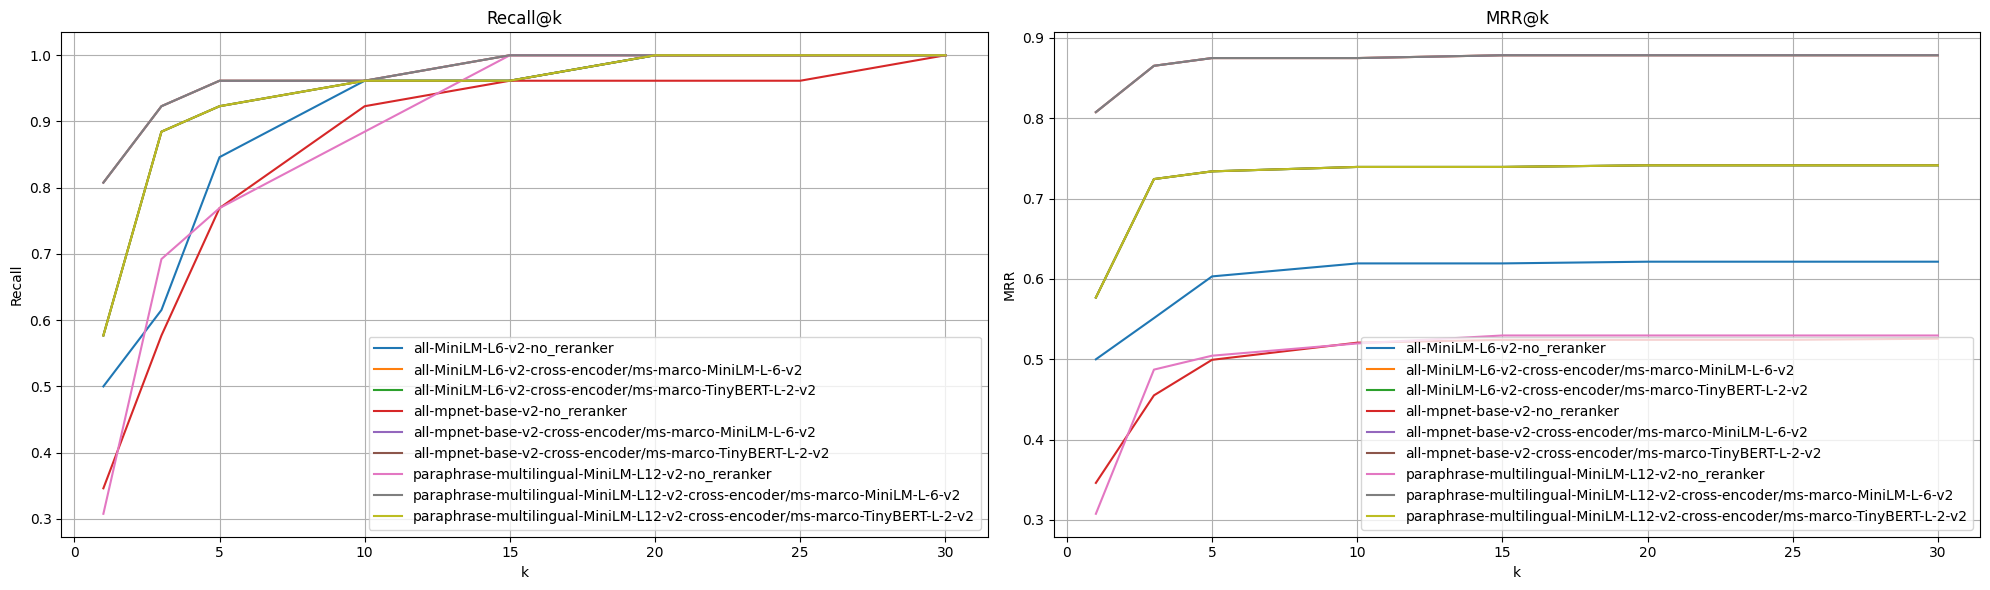

In [65]:
import matplotlib.pyplot as plt

df = results

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# plot recall
recall_data = df[(df["metric"] == "recall")]
for embedding_model in df["embedding_model"].unique():
    for reranker in df["reranker_model"].unique():
        data = recall_data[(recall_data["reranker_model"] == reranker) & (recall_data["embedding_model"] == embedding_model)]
        ax1.plot(data["k"], data["mean_score"], label=f"{embedding_model}-{reranker}")
ax1.set_title("Recall@k")
ax1.set_xlabel("k")
ax1.set_ylabel("Recall")
ax1.grid(True)
ax1.legend()

# plot MRR
mrr_data = df[(df["metric"] == "mrr")]
for embedding_model in df["embedding_model"].unique():
    for reranker in df["reranker_model"].unique():
        data = mrr_data[(mrr_data["reranker_model"] == reranker) & (mrr_data["embedding_model"] == embedding_model)]
        ax2.plot(data["k"], data["mean_score"], label=f"{embedding_model}-{reranker}")
ax2.set_title("MRR@k")
ax2.set_xlabel("k")
ax2.set_ylabel("MRR")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()